In [2]:
!pip3 install pygame

     |████████████████████████████████| 11.4MB 42.9MB/s 


In [0]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


Data description : 
 One array of size 32
 - the result of the remaing dices action : four slots
   The numbers go from 0 to 6 : 0 if already played it
  
 - the board state composed of :
      - 24 first digit from -9 to +9 for black and white pins on the arrows
      - 2 folowing for number of pins that finished : white and black
      - 2 last for number of pins in prison : white and black

The output represents the space of possible actions.
We need to map every possible action to an integer.
We have 25 slots from where a pin can move with all 6 possible dice rolls, which leads to 150 possible actions.  



In [0]:
input_size_ = 32
output_size_ = 175


This function take as an argument an integer from 0 to 149 and returns a tuple (i,j,k) where : 
  - i = arrow id
  - value of dice used
  - -1, 0 or 1 if the pin eats another one, nothing particular, the pin goes out


In [0]:
def compute_action_space():
  table = np.array([[[0]*2]*7]*25)
  for k in range(25):
    for l in range(7):
      table[k][l][0] = k
      table[k][l][1] = l
  return table

action_space = compute_action_space()

def get_action(indx):
  """
    Converts index in [0,174] range to coresponding move
  """
  pos, roll = action_space[indx//7][indx%7]
  return (pos, roll)

def get_idx(action):
  """
    Inverse operation of previous function
  """
  pos, roll = action
  return pos*7+roll


Let's create a functions to help later.

In [0]:
def get_score(board):
  """
    Gives scores from a board of size 28 (without dices rolls)
    Normalized.
  """
  if board[24] == 15 :
    return 1
  else :
    max_score = 15*24
    result = 0
    result+= (board[24]-board[25])*24
    for k,pins in enumerate(board[:24]) :
      pos = 23 - k
      if pins > 0 :
        if pins > 1 :
          result += pins*((pos//6+1)*6)
        else :
          result+= (pos//6)*6 + 1
    return result/max_score
    

def max_value(resulting_states):
  """
    Takes a list of stae and returns
    s : the state having the highest score
    m : the corresponding state score
    i : the corresponfing index in the list
  """
  s = resulting_states[0]
  m = get_score(s.board)
  i=0
  for k,res in enumerate(resulting_states[1:]) :
    sc = get_score(res.board)
    if sc > m :
      m = sc
      s = res
      i=k
  return m,s,i

Now we can use gym and write the data generation loop.

First lets load the necessary files.

We will need a structure to store the data we generate.

In [0]:
class data_manager():
  def __init__(self, df_size):
    self.df = []
    self.df_size_ = df_size

  def reset(self):
    self.df = []

  def is_full(self):
    return len(self.df) == self.df_size_

  def add(self, plays):
    to_add = plays.copy()
    if self.is_full():
      print("already full")
    else :
      for play in to_add :
        self.df.append(play)

  def get_df(self):
    return np.array(self.df)

  def get_size(self):
    return len(self.df)

  def dump(self, x):
    nb = int((1-x)*self.get_size())
    idx = np.random.randint(low = 0, high = self.get_size(), size = nb, dtype = int)
    self.df = list(np.array(self.df)[idx])




In [9]:
%cd content/

[Errno 2] No such file or directory: 'content/'
/content


In [11]:
!git clone https://github.com/jcGourcuff/BackGammon.git

Cloning into 'BackGammon'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 218 (delta 91), reused 202 (delta 75), pack-reused 0
Receiving objects: 100% (218/218), 300.40 KiB | 411.00 KiB/s, done.
Resolving deltas: 100% (91/91), done.


In [12]:
%cd BackGammon/gym_backgammon/

/content/BackGammon/gym_backgammon


In [13]:
from envs.backgammon_env import BackgammonEnv
from envs.backgammon import State, WhiteAgent, reverse_view

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


Now let's create the model.

In [0]:
class BackgammonNet(nn.Module):
  def __init__(self):
    super(BackgammonNet, self).__init__()
    self.input_size = 32
    self.output_size = 175
    
    self.layer_0 = nn.Sequential(nn.Linear(self.input_size,self.input_size),
                                    nn.ReLU(inplace=True))

    self.growing_layer_2 = nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(2*self.input_size,2*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.growing_layer_3 = nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(3*self.input_size,3*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.growing_layer_4 = nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(4*self.input_size,4*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.growing_layer_5 = nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(5*self.input_size,5*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.growing_layer_6 = nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(6*self.input_size,6*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.growing_layer_7 = nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(7*self.input_size,7*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.growing_layer_8 = nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(8*self.input_size,8*self.input_size),
                                    nn.ReLU(inplace=True))
                                



    self.res_layer_1 =  nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(8*self.input_size,8*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.res_layer_2 =  nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(8*self.input_size,8*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.res_layer_3 =  nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(8*self.input_size,8*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.res_layer_4 =  nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(8*self.input_size,8*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.res_layer_5 =  nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(8*self.input_size,8*self.input_size),
                                    nn.ReLU(inplace=True))
    
    self.res_layer_6 =  nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(8*self.input_size,8*self.input_size),
                                    nn.ReLU(inplace=True))

    self.fc = nn.Sequential(nn.Dropout(inplace = False),
                                    nn.Linear(8*self.input_size,self.output_size))
    
    
  def forward(self,x):
    mem_x = x

    x = self.layer_0(x)

    x = torch.cat([x,mem_x], dim = -1)
    x = self.growing_layer_2(x)

    x = torch.cat([x,mem_x], dim = -1)
    x = self.growing_layer_3(x)

    x = torch.cat([x,mem_x], dim = -1)
    x = self.growing_layer_4(x)

    x = torch.cat([x,mem_x], dim = -1)
    x = self.growing_layer_5(x)

    x = torch.cat([x,mem_x], dim = -1)
    x = self.growing_layer_6(x)

    x = torch.cat([x,mem_x], dim = -1)
    x = self.growing_layer_7(x)

    x = torch.cat([x,mem_x], dim = -1)
    x = self.growing_layer_8(x)

    x = self.res_layer_1(x) + x
    x = self.res_layer_2(x) + x
    x = self.res_layer_3(x) + x
    x = self.res_layer_4(x) + x
    x = self.res_layer_5(x) + x
    x = self.res_layer_6(x) + x

    x = self.fc(x)

    return x





Let's also choose a learning rate and an optimizer.

In [0]:
loss_fn = nn.MSELoss().to(device)
learning_rate = 1e-3

model_rand = BackgammonNet().to(device)
model_greed = BackgammonNet().to(device)
optimizer_rand = torch.optim.SGD(model_rand.parameters(), lr=learning_rate, momentum=0.9)
optimizer_greed = torch.optim.SGD(model_greed.parameters(), lr=learning_rate, momentum=0.9)
scheduler_rand = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_rand, patience = 100, factor = 0.1, verbose = True)
scheduler_greed = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_greed, patience = 100, factor = 0.1, verbose = True)


sigmoid = nn.functional.sigmoid
action_space = compute_action_space()

In [0]:
nb_episodes = 50
Backenv_rand = BackgammonEnv()
Backenv_greed = BackgammonEnv(black_ia = 'greed')
max_steps = 1000
gamm = .9
epsilon = .5
epsilon_min = .01
epsilon_decay = .75

In [0]:
def convert_roll(dice_roll):
  """
    takes a double as input, returns dices rolls of size 4 (to prevent doubles)
  """
  roll = dice_roll
  if roll[0]!=roll[1]:
    return roll+ [0,0]
  else : 
    return roll + roll
 

def get_next_move(state, dice, eps, nb_wrong_moves = 2):
  """
  From a board state and a roll, chooses next move s.t. :
    with prob 1-e greedy approach
    with prob e random approach

  Returns the chosen state, the corresponding move, Q(sate, move), Q(next_state, best_move), boolean ==1 if game finished
  """
  init_state = State(state = state)

  white = WhiteAgent(init_state)

  possible_moves = white.possible_moves(dice)
  good_move, wrong_moves, next_state, reward = None, None, None, 0

  poss_moves_idx = [get_idx(mov) for mov in possible_moves]
  wrong_moves_idxs = [k  for k in range(175) if k not in poss_moves_idx] 
  wrong_moves = np.random.choice(wrong_moves_idxs, size = nb_wrong_moves)

  if np.random.uniform(0, 1) > eps:
      possible_next_states = [State(state = init_state, move = m) for m in possible_moves]
      _, next_state, idx = max_value(possible_next_states)
      move = possible_moves[idx]

  else :
      move = possible_moves[np.random.randint(len(possible_moves))]
      next_state = State(state = init_state, move = move)
      
  reward = get_score(next_state.board)-get_score(init_state.board)

  finished = (next_state.board[24]==15)|(next_state.board[25]==15)

  if next_state.board[24]==15 : #game won
    reward = 1
     
  return next_state, move, reward, finished, wrong_moves


Let's write the training loop.

In [0]:
def play_and_train(model,optimizer, scheduler, env,  nb_game, fact_wrong_mov = 1, batch_size = 10, 
                   epsilon = .9, gamma = .9, max_steps = 200, verbose =False, dump_ratio = .1):
  eps = epsilon
  buffer = data_manager(4*nb_game*max_steps)
  game = 0
  running_loss = 0.0

  nb_back_grad = 0.0

  losses = []

  while game < nb_game :

      env.reset() 
      done = False        #decides whether the game is over
      k=0

      if verbose : 
        print("start game "+str(game +1))

      while k < max_steps : 
      
        #white throws the dice
        white_roll = [np.random.randint(1, 7), np.random.randint(1, 7)]
        rolls = convert_roll(white_roll)
        rolls_input = rolls.copy()
        
        init_state = State(state = env.game.state)

        #to store the set of moves 
        action = []

        if verbose :
          print("turn {}".format(k), end = '\r')

        for i,roll in enumerate(rolls) :

          if roll >0 : #means the turn is not done yet

            next_state, good_move, reward, finished, wrong_moves = get_next_move(init_state, roll, eps = eps, nb_wrong_moves = fact_wrong_mov)
            
            action.append(good_move)

            state_input =  rolls_input + init_state.board.copy()

            rolls_input[i] = 0

            next_state_input =  rolls_input + next_state.board.copy()

            buffer.add([[state_input, get_idx(good_move), next_state_input, reward, finished]])

            for mov in wrong_moves :
              buffer.add([[state_input, mov, None, 0., False]])
            
            init_state = State(state = next_state)

            print(init_state.board)

            if finished :
              done = True
          
          else:
            break

        _, _, _, _ = env.step(action)

        #samlpe random minibatch from the buffer
        if buffer.get_size() > batch_size : 
          nb_back_grad +=1

          idxs = np.random.randint(len(buffer.df), size = batch_size)

          batch = buffer.get_df()[idxs,:]

          model.eval()

          targets = []

          moves_idx = []
          for line in batch : 

            _, move_idx, next_state_input, reward, finished = line

            moves_idx.append(move_idx)

            if (next_state_input is not None) and (not finished) :

              if (np.sum(next_state_input[:4])>0) :
              
                next_state_input = torch.FloatTensor(next_state_input).to(device)

                reward = reward + gamma*torch.max(model(next_state_input))

              else :

                blackboard = reverse_view(next_state_input[4:])
                
                black_roll = [np.random.randint(1, 7), np.random.randint(1, 7)]
                black_roll = convert_roll(black_roll)

                black_input = torch.FloatTensor(black_roll + blackboard).to(device)

                reward = reward - gamma*torch.max(model(black_input))

              
            targets.append(reward)

          moves_idx = torch.LongTensor(moves_idx).to(device)
          anx = torch.LongTensor(np.arange(batch_size)).to(device)

          targets = torch.as_tensor(targets).to(device)

          model.train()

          inputs = torch.FloatTensor([line[0] for line in batch]).to(device)

          outs = model(inputs)

          outs = outs[anx,moves_idx]

          loss = loss_fn(outs, targets)

          optimizer.zero_grad()

          loss.backward()

          optimizer.step()

          l = loss.data.item()

          running_loss += l

        k+=1

        if done:
          game +=1
          break

      mean_loss = running_loss/(batch_size*nb_back_grad)

      scheduler.step(mean_loss)

      losses.append(mean_loss)

      print("game {} mean_loss {}".format(game,mean_loss))

      buffer.dump(dump_ratio)

      if ((game+1)%50 == 0) and (eps >= epsilon_min) :
          eps *= epsilon_decay

  return losses

In [20]:
losses_rand = play_and_train(model_rand, optimizer_rand, scheduler_rand, Backenv_rand, nb_game = 500)

game 1 mean_loss 0.21526903148602555
game 2 mean_loss 0.12011268049370027
game 3 mean_loss 0.07867481559515
game 4 mean_loss 0.05376095494103371
game 5 mean_loss 0.0429676202074939
game 6 mean_loss 0.037834187440511556
game 7 mean_loss 0.03380559019843522
game 8 mean_loss 0.029097549701441447
game 9 mean_loss 0.02720221364725432
game 10 mean_loss 0.0243839740969086
game 11 mean_loss 0.022595262014646147
game 12 mean_loss 0.020308506620507212
game 13 mean_loss 0.018943087826452557
game 14 mean_loss 0.017431989520419865
game 15 mean_loss 0.015793233851983345
game 16 mean_loss 0.014360227612233574
game 17 mean_loss 0.013930981526591328
game 18 mean_loss 0.013362800512809659
game 19 mean_loss 0.012468198035717797
game 20 mean_loss 0.012161223819922523
game 21 mean_loss 0.011825312640931483
game 22 mean_loss 0.01155475580039208
game 23 mean_loss 0.011131756372835004
game 24 mean_loss 0.010849403350058436
game 25 mean_loss 0.010519753014937648
game 26 mean_loss 0.010322652572053358
game 27 m

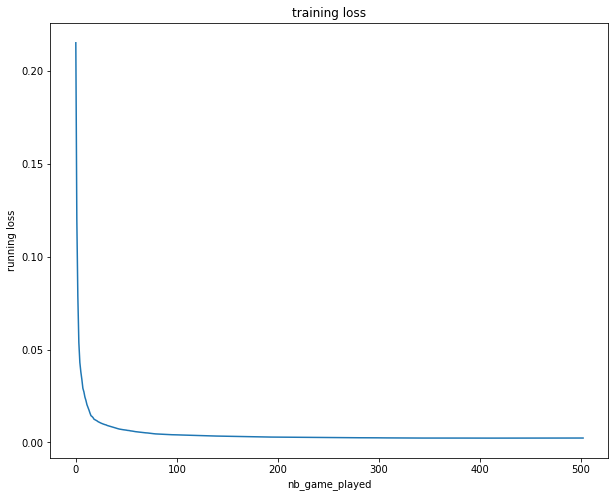

In [21]:
import matplotlib.pyplot as plt

X = np.arange(len(losses_rand))

plt.figure(figsize = (10,8))
plt.plot(X, losses_rand)
plt.title("training loss")
plt.xlabel("nb_game_played")
plt.ylabel("running loss")
plt.show()

In [22]:
losses_greed = play_and_train(model_greed,optimizer_greed, scheduler_greed, Backenv_greed, nb_game = 500)

game 1 mean_loss 0.3164464408159256
game 2 mean_loss 0.1386051793966223
game 3 mean_loss 0.09491633476454367
game 4 mean_loss 0.07538449581138286
game 5 mean_loss 0.05872836713465038
game 6 mean_loss 0.04842345154389392
game 7 mean_loss 0.0448133392124734
game 8 mean_loss 0.039424150156685045
game 9 mean_loss 0.03646551982775254
game 10 mean_loss 0.03296572575133328
game 11 mean_loss 0.029338186206096874
game 12 mean_loss 0.027782661834731697
game 13 mean_loss 0.024704223647672902
game 14 mean_loss 0.0232363773977422
game 15 mean_loss 0.02246910228919099
game 16 mean_loss 0.021317943728753123
game 17 mean_loss 0.020374114182204833
game 18 mean_loss 0.019522013598048504
game 19 mean_loss 0.01816662965225449
game 20 mean_loss 0.017464539942136842
game 21 mean_loss 0.016828184531264702
game 22 mean_loss 0.016115091600605355
game 23 mean_loss 0.015624473803981877
game 24 mean_loss 0.015091618851023223
game 25 mean_loss 0.014263865867246034
game 26 mean_loss 0.013453919985108158
game 27 mea

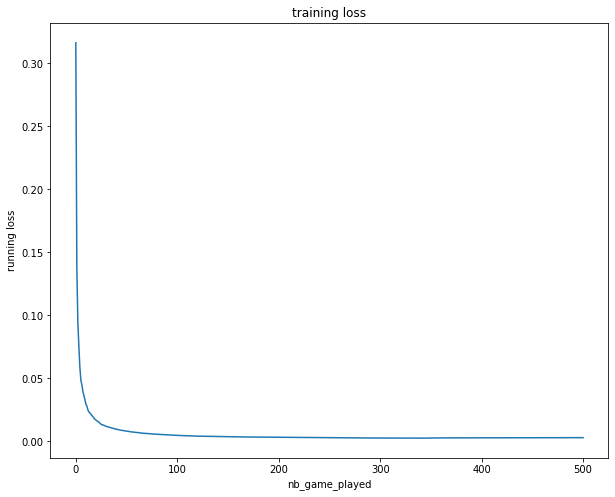

In [23]:
X = np.arange(len(losses_greed))

plt.figure(figsize = (10,8))
plt.plot(X, losses_greed)
plt.title("training loss")
plt.xlabel("nb_game_played")
plt.ylabel("running loss")
plt.show()

In [0]:
def get_agent_move(outs, pos_moves):
  q_values = outs.detach().numpy()
  idxs = [get_idx(move) for move in pos_moves]
  m = q_values[idxs[0]]
  move_idx = 0

  for k, i in enumerate(idxs[1:]):
    if q_values[i] > m :
      m = q_values[i]
      move_idx = k + 1

  return pos_moves[move_idx] 

In [0]:
def test_ia(model, nb_games, env, max_steps = 100, verbose = False):
  eps = epsilon
  game = 0
  game_win = 0
  model.eval()
  stats = {"output":[], "possible_moves" : []}

  while game < nb_games :

      env.reset() 
      done = False        #decides whether the game is over
      k=0

      if verbose : 
        print("start game "+str(game +1))

      while k < max_steps : 
      
        #white throws the dice
        white_roll = [np.random.randint(1, 7), np.random.randint(1, 7)]
        rolls = convert_roll(white_roll)
        rolls_input = rolls.copy()
        
        init_state = State(state = env.game.state)

        #to store the set of moves 
        action = []
        
        if verbose :
          print("turn {}".format(k), end = '\r')

        for i,roll in enumerate(rolls) :

          if roll >0 : #means the turn is not done yet
            roll_for_dataset = rolls_input.copy()

            modelInput =  torch.FloatTensor(roll_for_dataset + init_state.board.copy()).to(device)

            out = model(modelInput)

            white = WhiteAgent(init_state)
            possible_moves = white.possible_moves(roll)

            stats["output"].append(out.detach().numpy())
            stats["possible_moves"].append([get_idx(mov) for mov in possible_moves])

            move = get_agent_move(out, possible_moves)
            init_state = State(state = init_state, move = move)

            action.append(move)

            rolls_input[i]=0
          
          else:
            break

        _, _, _, _ = env.step(action)

        k+=1

        current_board = env.game.state.board
        if current_board[24]==15 :
          game_win+=1
          game+=1
          break
        elif init_state.board[25]==15 :
          game+=1
          break
        
        
      print("game {} nb_won {}".format(game, game_win))
  return stats

In [0]:
rand_env = BackgammonEnv()
greed_env = BackgammonEnv('greed')

In [27]:
stats_rand_vs_rand = test_ia(model_rand, 100, rand_env)

game 1 nb_won 1
game 2 nb_won 2
game 3 nb_won 3
game 4 nb_won 3
game 5 nb_won 3
game 6 nb_won 4
game 7 nb_won 5
game 8 nb_won 6
game 9 nb_won 6
game 10 nb_won 7
game 11 nb_won 8
game 12 nb_won 9
game 13 nb_won 10
game 14 nb_won 11
game 15 nb_won 12
game 16 nb_won 13
game 17 nb_won 14
game 18 nb_won 15
game 19 nb_won 16
game 20 nb_won 17
game 21 nb_won 18
game 22 nb_won 19
game 23 nb_won 20
game 24 nb_won 21
game 25 nb_won 22
game 26 nb_won 23
game 27 nb_won 24
game 28 nb_won 25
game 29 nb_won 26
game 30 nb_won 27
game 31 nb_won 28
game 32 nb_won 29
game 33 nb_won 30
game 34 nb_won 31
game 35 nb_won 32
game 36 nb_won 33
game 37 nb_won 34
game 38 nb_won 35
game 39 nb_won 36
game 40 nb_won 37
game 41 nb_won 37
game 42 nb_won 38
game 43 nb_won 39
game 44 nb_won 40
game 45 nb_won 41
game 46 nb_won 42
game 47 nb_won 43
game 48 nb_won 44
game 49 nb_won 45
game 50 nb_won 46
game 51 nb_won 47
game 52 nb_won 47
game 53 nb_won 48
game 54 nb_won 49
game 55 nb_won 50
game 56 nb_won 51
game 57 nb_wo

In [28]:
stats_rand_vs_greed = test_ia(model_rand, 100, greed_env)

game 1 nb_won 1
game 2 nb_won 2
game 3 nb_won 3
game 4 nb_won 4
game 5 nb_won 4
game 6 nb_won 4
game 7 nb_won 4
game 8 nb_won 5
game 9 nb_won 6
game 10 nb_won 7
game 11 nb_won 8
game 12 nb_won 8
game 13 nb_won 9
game 14 nb_won 10
game 15 nb_won 11
game 16 nb_won 11
game 17 nb_won 12
game 18 nb_won 13
game 19 nb_won 14
game 20 nb_won 15
game 21 nb_won 16
game 22 nb_won 17
game 23 nb_won 18
game 24 nb_won 19
game 25 nb_won 19
game 26 nb_won 20
game 27 nb_won 21
game 28 nb_won 22
game 29 nb_won 22
game 30 nb_won 23
game 31 nb_won 24
game 32 nb_won 25
game 33 nb_won 25
game 34 nb_won 26
game 35 nb_won 26
game 36 nb_won 26
game 37 nb_won 27
game 38 nb_won 28
game 39 nb_won 29
game 40 nb_won 29
game 41 nb_won 30
game 42 nb_won 31
game 43 nb_won 31
game 44 nb_won 31
game 45 nb_won 32
game 46 nb_won 32
game 47 nb_won 33
game 48 nb_won 34
game 49 nb_won 35
game 50 nb_won 35
game 51 nb_won 36
game 52 nb_won 37
game 53 nb_won 38
game 54 nb_won 39
game 55 nb_won 40
game 56 nb_won 41
game 57 nb_won

In [29]:
stats_greed_vs_rand = test_ia(model_greed, 100, rand_env)

game 1 nb_won 1
game 2 nb_won 2
game 3 nb_won 3
game 4 nb_won 4
game 5 nb_won 5
game 6 nb_won 6
game 7 nb_won 7
game 8 nb_won 8
game 9 nb_won 9
game 10 nb_won 10
game 11 nb_won 11
game 12 nb_won 12
game 13 nb_won 13
game 14 nb_won 13
game 15 nb_won 14
game 16 nb_won 15
game 17 nb_won 16
game 18 nb_won 17
game 19 nb_won 18
game 20 nb_won 19
game 21 nb_won 20
game 22 nb_won 21
game 23 nb_won 21
game 24 nb_won 22
game 25 nb_won 23
game 26 nb_won 23
game 27 nb_won 24
game 28 nb_won 25
game 29 nb_won 26
game 30 nb_won 27
game 31 nb_won 28
game 32 nb_won 29
game 33 nb_won 30
game 34 nb_won 31
game 35 nb_won 32
game 36 nb_won 33
game 37 nb_won 34
game 38 nb_won 35
game 39 nb_won 36
game 40 nb_won 37
game 41 nb_won 38
game 42 nb_won 39
game 43 nb_won 39
game 44 nb_won 40
game 45 nb_won 41
game 46 nb_won 42
game 47 nb_won 43
game 48 nb_won 44
game 49 nb_won 45
game 50 nb_won 46
game 51 nb_won 47
game 52 nb_won 47
game 53 nb_won 48
game 54 nb_won 49
game 55 nb_won 50
game 56 nb_won 50
game 57 nb

In [30]:
stats_greed_vs_greed = test_ia(model_greed, 100, greed_env)

game 1 nb_won 0
game 2 nb_won 1
game 3 nb_won 2
game 4 nb_won 3
game 5 nb_won 4
game 6 nb_won 5
game 7 nb_won 6
game 8 nb_won 7
game 9 nb_won 8
game 10 nb_won 8
game 11 nb_won 9
game 12 nb_won 9
game 13 nb_won 10
game 14 nb_won 11
game 15 nb_won 12
game 16 nb_won 13
game 17 nb_won 13
game 18 nb_won 14
game 19 nb_won 15
game 20 nb_won 16
game 21 nb_won 16
game 22 nb_won 17
game 23 nb_won 18
game 24 nb_won 19
game 25 nb_won 20
game 26 nb_won 21
game 27 nb_won 21
game 28 nb_won 22
game 29 nb_won 23
game 30 nb_won 24
game 31 nb_won 24
game 32 nb_won 25
game 33 nb_won 26
game 34 nb_won 26
game 35 nb_won 26
game 36 nb_won 27
game 37 nb_won 27
game 38 nb_won 28
game 39 nb_won 29
game 40 nb_won 30
game 41 nb_won 30
game 42 nb_won 30
game 43 nb_won 31
game 44 nb_won 31
game 45 nb_won 32
game 46 nb_won 33
game 47 nb_won 34
game 48 nb_won 35
game 49 nb_won 36
game 50 nb_won 36
game 51 nb_won 37
game 52 nb_won 38
game 53 nb_won 39
game 54 nb_won 40
game 55 nb_won 40
game 56 nb_won 41
game 57 nb_wo

In [0]:
def read_stats(stats):
  print("nb of data : {}".format(len(stats["output"])))
  #we separate computed_q_values that correspond to possible moves and the others
  possible_q_values = []
  impossible_q_values = []

  max_possible_q_values = []
  min_possible_q_values = []

  max_impossible_q_values = []
  min_impossible_q_values = []

  possible_outputs = []
  impossible_outputs = []

  print("unpacking data...")
  for output, idxs in zip(stats["output"], stats["possible_moves"]):
    mask = np.array([(i in idxs) for i in range(len(output))])
    possible = list(output[mask])
    impossible = list(output[~mask])

    possible_outputs.append(possible)
    impossible_outputs.append(impossible)

    possible_q_values = possible_q_values + possible
    impossible_q_values = impossible_q_values + impossible

    max_possible_q_values.append(max(possible))
    min_possible_q_values.append(min(possible))

    max_impossible_q_values.append(max(impossible))
    min_impossible_q_values.append(min(impossible))

  res = 0.01

  print("computing plots...")
  ### 
  mean_poss = np.round(np.mean(possible_q_values),decimals = 4)
  std_poss = np.round(np.std(possible_q_values),decimals = 4)

  max_poss = max(possible_q_values)
  min_poss = min(possible_q_values)
  N_poss = int(np.floor((max_poss-min_poss)/res)) + 1

  X_bar_poss = [min_poss + k*res for k in range(N_poss)]
  X_bar_poss[-1] = X_bar_poss[-1] + res/10
  height_poss = [0]*(N_poss -1)
  for k in range(N_poss-1) : 
    mask = np.array([((q>=X_bar_poss[k])&(q<X_bar_poss[k+1])) for q in possible_q_values])
    height_poss[k] = np.sum(mask)/len(possible_q_values)
  X_bar_poss = [x + res/2 for x in X_bar_poss[:-1]]

  ###
  mean_imposs = np.round(np.mean(impossible_q_values),decimals = 4)
  std_imposs = np.round(np.std(impossible_q_values),decimals = 4)

  max_imposs = max(impossible_q_values)
  min_imposs = min(impossible_q_values)
  N_imposs = int(np.floor((max_imposs-min_imposs)/res)) + 1

  X_bar_imposs = [min_imposs + k*res for k in range(N_imposs)]
  X_bar_imposs[-1] = X_bar_imposs[-1] + res/10
  height_imposs = [0]*(N_imposs -1)
  for k in range(N_imposs-1) : 
    mask = np.array([((q>=X_bar_imposs[k])&(q<X_bar_imposs[k+1])) for q in impossible_q_values])
    height_imposs[k] = np.sum(mask)/len(impossible_q_values)
  X_bar_imposs = [x + res/2 for x in X_bar_imposs[:-1]]

  ###
  plt.figure(figsize = (10,8))

  ax1 = plt.subplot(1,2,1)

  plt.bar(X_bar_poss, height_poss, width = res)
  plt.xlabel("Q value")
  plt.ylabel("Frequency")
  plt.title("Q values distribution for possible moves")
  plt.text(.7,.9,"mean: "+str(mean_poss)+"\n std: "+str(std_poss), transform=ax1.transAxes)
  #plt.xlim((.4,.6))

  ax2 = plt.subplot(1,2,2)

  plt.bar(X_bar_imposs, height_imposs, width = res)
  plt.xlabel("Q value")
  plt.ylabel("Frequency")
  plt.title("Q values distribution for impossible moves")
  plt.text(.7,.9,"mean: "+str(mean_imposs)+"\n std: "+str(std_imposs), transform=ax2.transAxes)
  #plt.xlim((.4,.6))

  plt.show()

  ###
  N = len(max_possible_q_values)//100
  dots1 = [np.mean(max_possible_q_values[k:100*(k+1)]) for k in range(N)]
  dots2 = [np.mean(min_possible_q_values[k:100*(k+1)]) for k in range(N)]
  dots3 = [np.mean(max_impossible_q_values[k:100*(k+1)]) for k in range(N)]
  dots4 = [np.mean(min_impossible_q_values[k:100*(k+1)]) for k in range(N)]

  plt.figure(figsize=(10,8))

  plt.scatter(np.arange(N), dots1, c = 'darkgreen', label = "max_possible_q_value", marker = 'o')
  plt.scatter(np.arange(N), dots2, c = 'lightgreen', label = "min_possible_q_value", marker = 'o')

  plt.scatter(np.arange(N), dots3, c = 'maroon', label = "max_impossible_q_value", marker = 'o')
  plt.scatter(np.arange(N), dots4, c = 'red', label = "min_impossible_q_value", marker = 'o')

  plt.ylabel("Q value")

  plt.title("Q values bounds for each registered play")

  plt.legend()

  plt.show()

  ###
  plt.figure(figsize=(10,8))

  for k, (poss, imposs) in enumerate(zip(possible_outputs, impossible_outputs)):

    plt.scatter(np.array([k]*len(poss)), poss, c = 'green', marker = 'o',)
    plt.scatter(np.array([k]*len(imposs)), imposs, c = 'red' , marker = 'o', alpha = .01)

  plt.ylabel("Q value")

  plt.title("Q values distribution")

  plt.show()

nb of data : 8142
unpacking data...
computing plots...


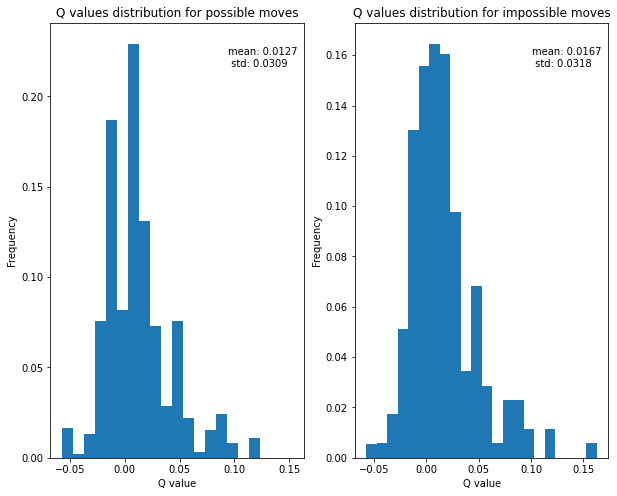

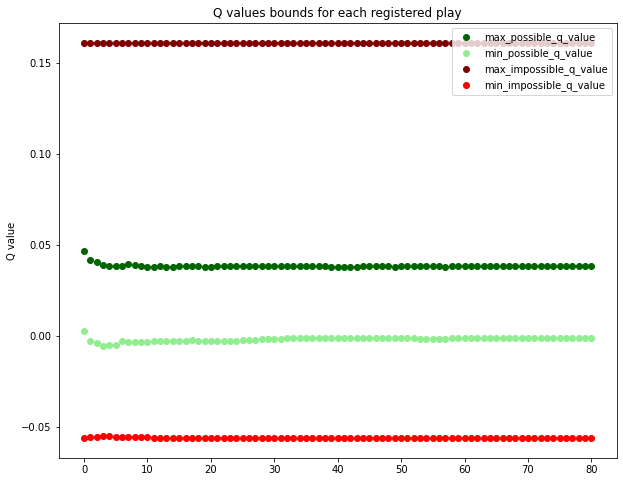

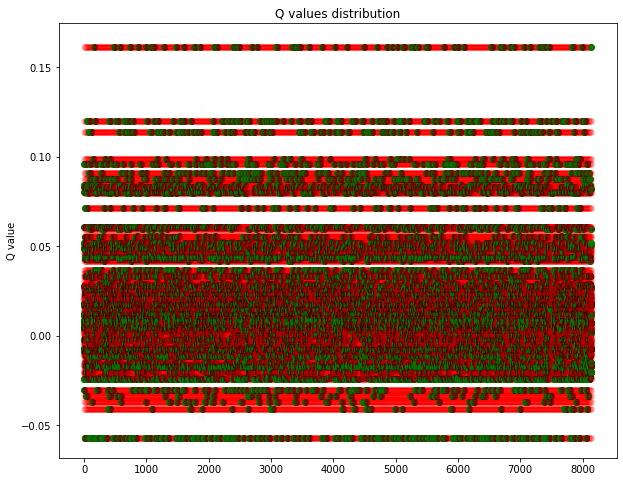

In [32]:
read_stats(stats_rand_vs_rand)

nb of data : 6576
unpacking data...
computing plots...


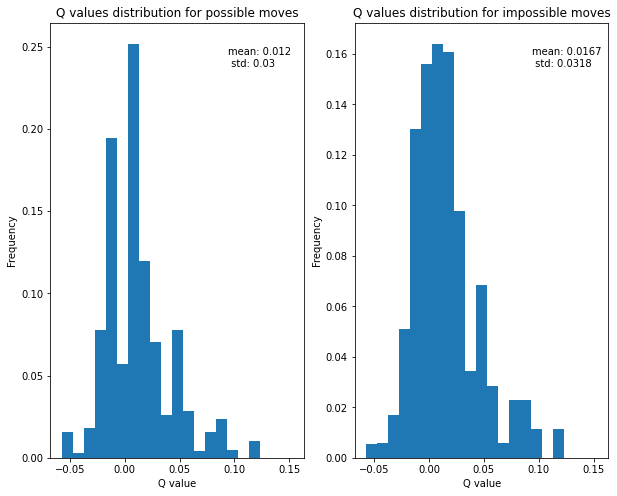

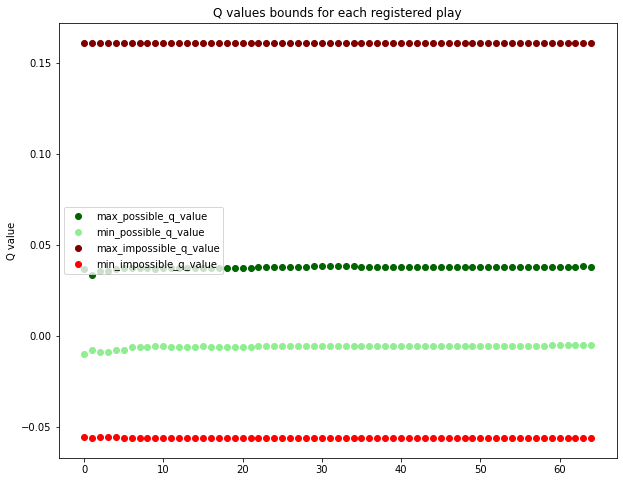

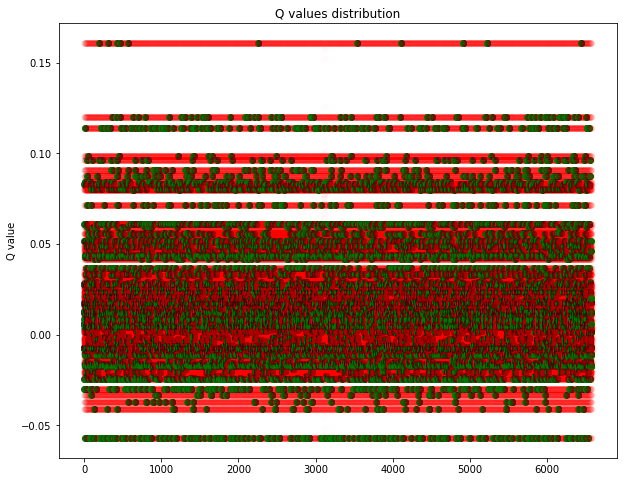

In [33]:
read_stats(stats_rand_vs_greed)

nb of data : 8040
unpacking data...
computing plots...


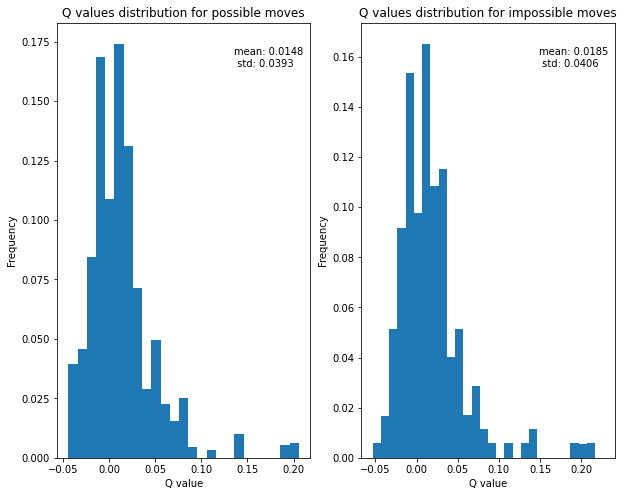

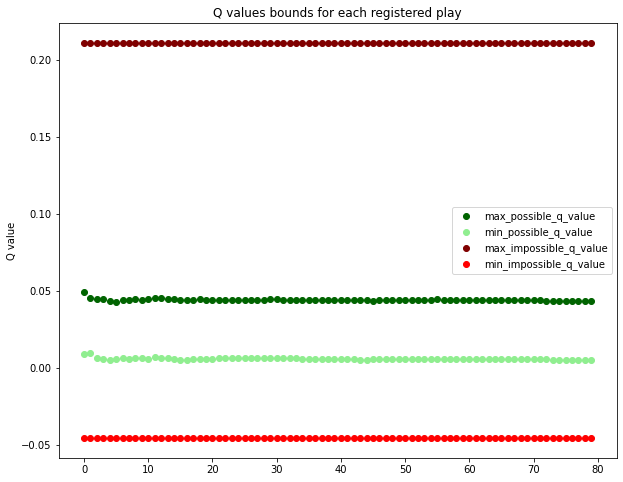

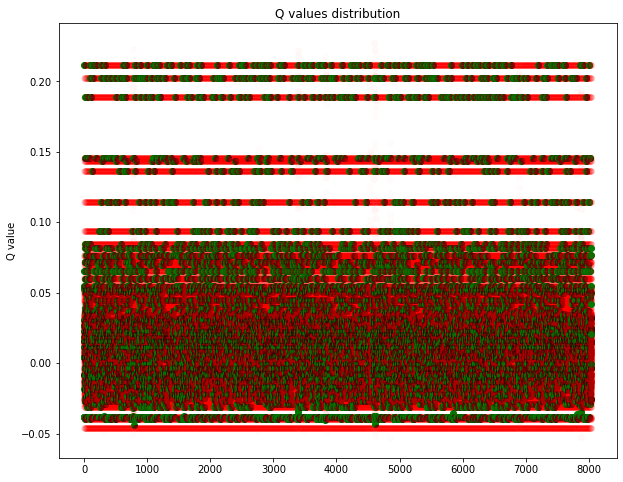

In [34]:
read_stats(stats_greed_vs_rand)

nb of data : 6162
unpacking data...
computing plots...


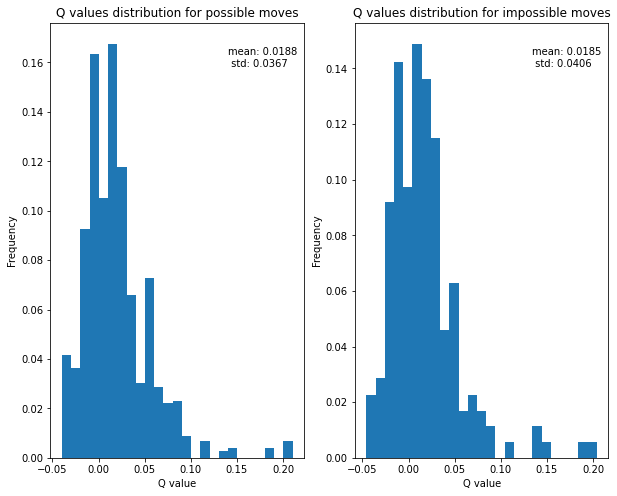

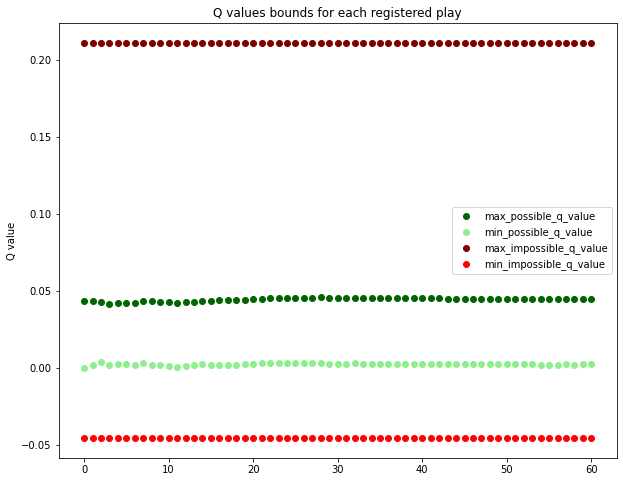

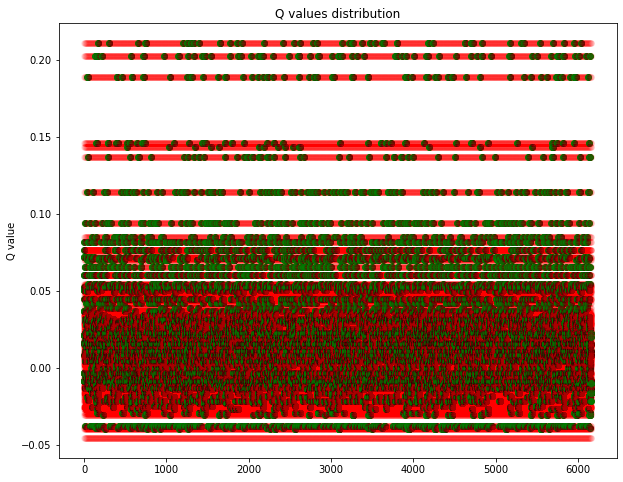

In [35]:
read_stats(stats_greed_vs_greed)